In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import data_prep as dp

path_abnb="//RT01FS21.DE.BOSCH.COM/KRS1BBH$/udacity/Data_Science/project_1_blogpost/data/"


sns.set(font_scale=1.5)
sns.set_style('ticks')

<b>Load AirBnB date from path_abnb:
- the data is organized by city in folders
- in each folder are the files
    - listings.csv
    - reviews.csv
    - calendar.csv
- the files are parsed and in the case of listings only mutual columns are kept in the join of different city files
- the city is then specified in the new column "folder"

In [2]:
listings, calendar, review=dp.load_data(path_abnb)

<b>Sum revenue from calendar up for each listing and provide in new dataframe:
- extract month of date column
- calculate revenue by month and year
- pivot the monthly sums by listing_id in "calendar_revenue"
- provide the unpivoted data in "calendar_stats"

In [3]:
calendar_revenue, calendar_stats=dp.analyze_calendar(calendar)

<b>Preprocessing of listings:
- df_vis is a merge of listings and the calendar_revenue results
- df is the ML ready dataframe after the merge calender_revenue results
    - filtering of irrelevant and duplicate data
    - dropping of nan-containing rows
    - using mode to convert non-numeric columns
    - removal of "$" and "%" and conversion into numeric columns
    - in order to quantify the influence of written descriptions or amenities I simply counted the number of characters w/o an analysis if it is a good or bad description

In [4]:
df_vis, df=dp.preprocess_listings(listings, calendar_revenue)

<b>Plot of the revenue_year distribution<b>:
- most of the distribution is between 0 and \\$200000
- there are lots of outliers above
- I chose \\$150000 as a cut-off to allow my linear regression model to find a stabil solution

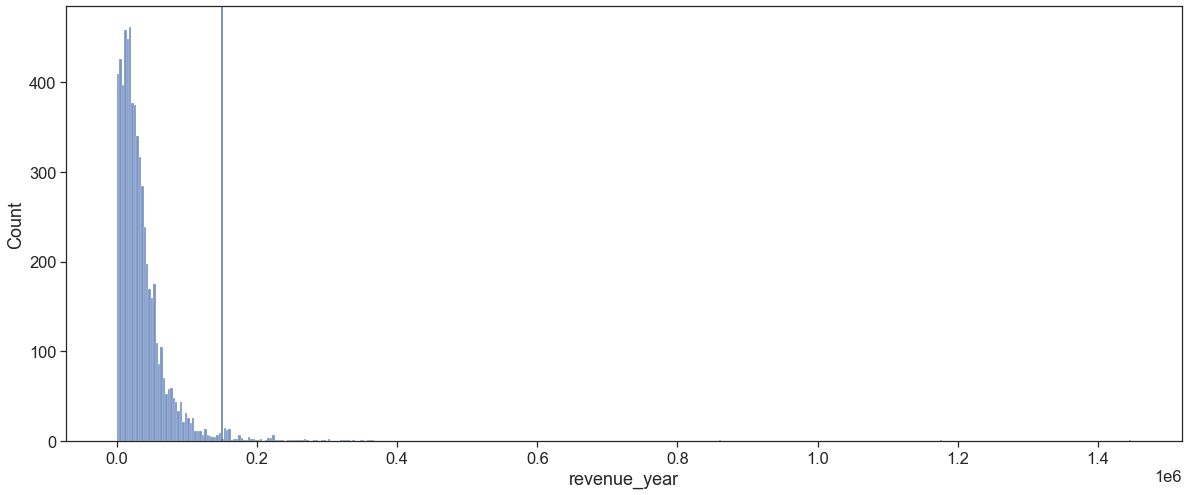

In [5]:
plt.figure(figsize=(20,8))
p2=sns.histplot(data=df_vis, x='revenue_year')
p2.axvline(150000)
plt.show()

<b>Plot of the distribution of "accommodates:
- the overall distribution is quite similar between the two cities
- Boston has more single person listings
- after 8 persons there are only few listings, which is why I chose to put a cut-off there

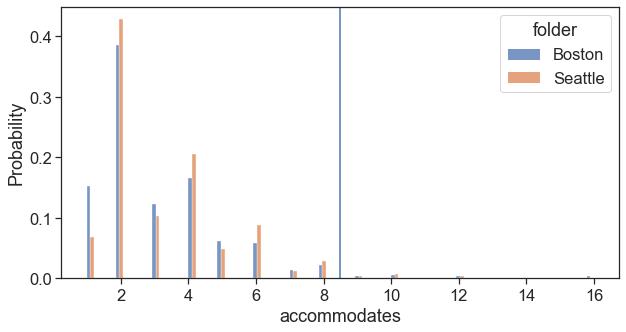

In [6]:
plt.figure(figsize=(10,5))
p3=sns.histplot(data=df_vis, x="accommodates", hue="folder", stat="probability", common_norm=False, multiple="dodge")
p3.axvline(8.5)
plt.show()

<b>Plot of listings per "neighbourhood_cleansed":
- in the first trials to apply a linear regression model the neighbourhoods with few listings disturbed the modelling
- I defined a cut-off at a minimum of 10 listings for a neighbourhood to be included

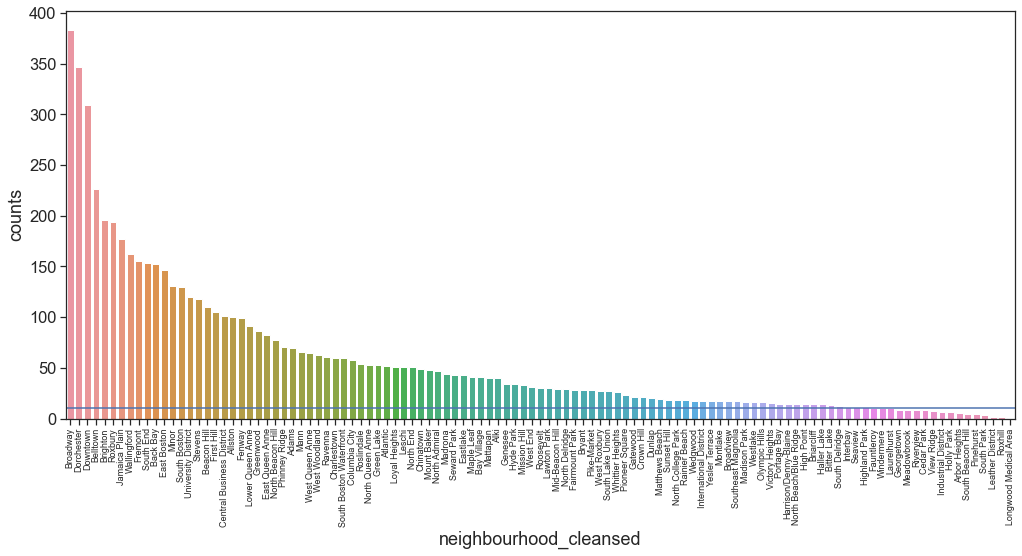

In [7]:
neighbourhoods=df_vis['neighbourhood_cleansed'].value_counts().reset_index().rename(columns={'index':'neighbourhood_cleansed', 'neighbourhood_cleansed':'counts'})
plt.figure(figsize=(17,7.5))
p3=sns.barplot(x="neighbourhood_cleansed", y="counts", data=neighbourhoods)
p3.axhline(10)
plt.xticks(rotation=90, fontsize=9)
plt.show()

<b>df_plot</b> is the version of df_vis that has all those previous cut-offs applied

In [8]:
df_plot=df_vis[(df_vis['revenue_year']<150000)&(df_vis['accommodates']<8.5)]
neighbourhoods=df_plot['neighbourhood_cleansed'].value_counts().reset_index()
remove_list=neighbourhoods[neighbourhoods['neighbourhood_cleansed']<10]['index'].to_list()
df_plot=df_plot[~df_plot['neighbourhood_cleansed'].isin(remove_list)]

In this plot the <b>revenue_year</b> is plotted against the number of people a listing <b>accommodates</b>
- Up to 8 people it is a near linear function
- the slope of it is not 1 though
- therefore you can expect more revenue per person for smaller listings

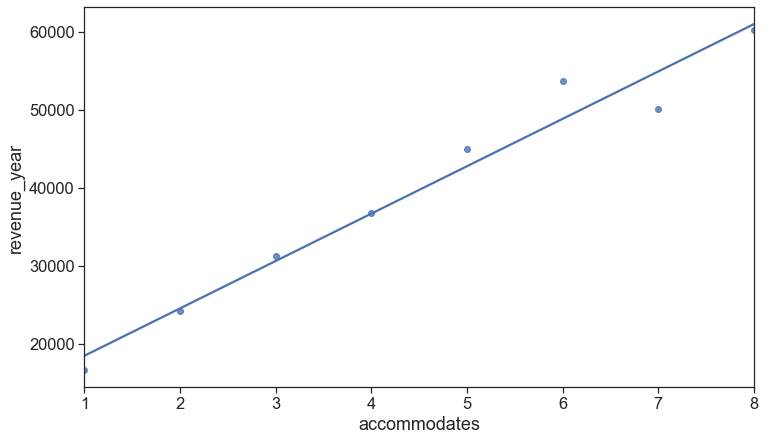

In [9]:
plt.figure(figsize=(12,7))
p5=sns.regplot(data=df_plot.groupby(by=['accommodates'], as_index=False)['revenue_year'].mean(), x="accommodates", y="revenue_year",ci=None)#, hue="folder")
plt.show()

I now applied a <b>linear modelling</b> to my dataset df to find the strongest influences to yearly revenue
- for that I dropped all columns that are duplicate (e.g., folder) or contain revenue information
- the r-squared is quite alright with about <b>0.73</b> for this

In [10]:
target='revenue_year'
drop=['revenue_year',1,2,3,4,5,6,7,8,9,10,11,12,'folder_Boston','folder_Seattle','revenue_month_mean']
lm_model_rev, X_train_rev=dp.regression_model(df,target, drop)

The r-squared score for your model was 0.7256273502060964 on 1369 values.


First I looked at the features that <b>positively</b> influence my revenue:

The answer is not surprising for any realtor... <b>location, location, location</b>

The same is true for the top 20 features that <b>negatively</b> influence my revenue

In [11]:
#Use the function and look at the top 30 
coef_df_rev = dp.coef_weights(lm_model_rev.coef_, X_train_rev)
coef_df_rev.nlargest(20,'coefs')

,est_int,coefs,abs_coefs
83,neighbourhood_cleansed_North End,25313.424125,25313.424125
36,neighbourhood_cleansed_Chinatown,20377.667414,20377.667414
34,neighbourhood_cleansed_Central Business District,17644.660885,17644.660885
25,neighbourhood_cleansed_Bay Village,17544.458340,17544.458340
27,neighbourhood_cleansed_Belltown,15171.797638,15171.797638
24,neighbourhood_cleansed_Back Bay,14604.533864,14604.533864
98,neighbourhood_cleansed_South Boston Waterfront,14140.442888,14140.442888
102,neighbourhood_cleansed_Southeast Magnolia,13897.850485,13897.850485
40,neighbourhood_cleansed_Downtown,13041.989948,13041.989948
88,neighbourhood_cleansed_Pioneer Square,12368.376000,12368.376000


In [12]:
coef_df_rev.nsmallest(20,'coefs')

,est_int,coefs,abs_coefs
56,neighbourhood_cleansed_High Point,-8911.204816,8911.204816
47,neighbourhood_cleansed_Fenway,-8267.105979,8267.105979
111,neighbourhood_cleansed_West Roxbury,-7954.811422,7954.811422
53,neighbourhood_cleansed_Greenwood,-3981.589198,3981.589198
31,neighbourhood_cleansed_Broadview,-3630.296652,3630.296652
70,neighbourhood_cleansed_Maple Leaf,-3362.840551,3362.840551
37,neighbourhood_cleansed_Columbia City,-3232.822140,3232.822140
54,neighbourhood_cleansed_Haller Lake,-2253.219099,2253.219099
72,neighbourhood_cleansed_Matthews Beach,-2046.330664,2046.330664
85,neighbourhood_cleansed_Olympic Hills,-1900.477993,1900.477993


The top influences were all neighbourhoods, but I also wanted to know which of the review scores 
- location is also here the number 1
- cleanliness is number 2

In [31]:
coef_df_rev[coef_df_rev['est_int'].str[0:6]=='review'].sort_values('coefs', ascending=False)

,est_int,coefs,abs_coefs
14,review_scores_location,1474.855628,1474.855628
6,review_scores_cleanliness,400.436824,400.436824
4,review_scores_rating,63.825192,63.825192
1,review_scores_accuracy,-2.773616,2.773616
12,review_scores_checkin,-17.095935,17.095935
2,review_scores_communication,-61.299566,61.299566
13,reviews_per_month,-239.683085,239.683085
8,review_scores_value,-723.691176,723.691176


The description of the listing or the neighbourhood seems rather unimportant. Only the number of listed amenities seems to count. A rather long name seems to be more repelling than inviting.

In [29]:
coef_df_rev[coef_df_rev['est_int'].str[-5:]=='count'].sort_values('coefs', ascending=False)

,est_int,coefs,abs_coefs
17,amenities_count,6.101816,6.101816
16,description_count,0.788921,0.788921
18,neighborhood_overview_count,0.640108,0.640108
19,name_count,-44.232381,44.232381


The plot of the yearly revenue by neighbourhood reflects the results of the linear model

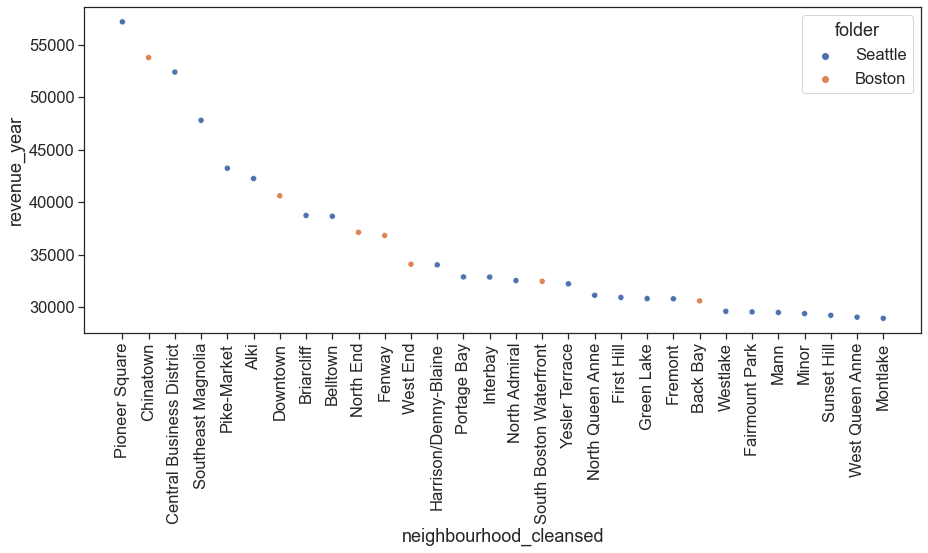

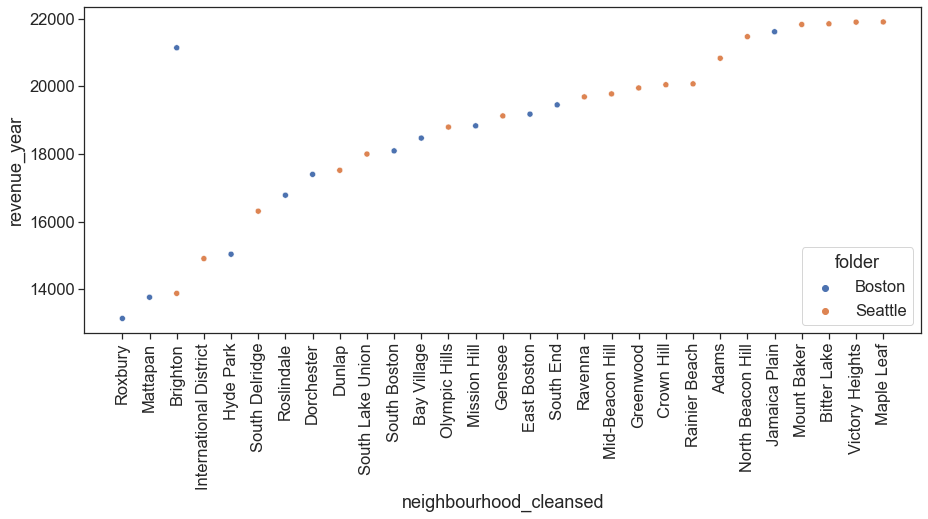

In [17]:
df_2=df_plot.groupby(by=['neighbourhood_cleansed','folder'], as_index=False)['revenue_year'].median()
plt.figure(figsize=(15,6))
p6=sns.scatterplot(data=df_2.nlargest(30,'revenue_year'), x="neighbourhood_cleansed", y="revenue_year", hue="folder")
plt.xticks(rotation=90)
plt.show()
plt.figure(figsize=(15,6))
p7=sns.scatterplot(data=df_2.nsmallest(30,'revenue_year'), x="neighbourhood_cleansed", y="revenue_year", hue="folder")
plt.xticks(rotation=90)
plt.show()